# 權值股監控
## 針對市值排名前30大之個股漲跌幅視覺化，挖掘今日強勢大型股

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance
import tejapi
import plotly.graph_objects as go
import requests as rq
from bs4 import BeautifulSoup
import json
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
import pandas_datareader as web
from datetime import datetime
import calendar

In [42]:
# 蒐集股票代碼 #
# 自證交所 https://www.twse.com.tw/zh/page/trading/fund/T86.html下載 2019/01/02 的成交資訊 #
nextlink = 'https://www.twse.com.tw/fund/T86?response=excel&date=20190102&selectType=ALLBUT0999'
nl_response = rq.get(nextlink, verify=False) # 用 requests 的 get 方法把網頁抓下來
soup = BeautifulSoup(nl_response.text, "html.parser") # 指定 作為解析器
a = json.loads(soup.text)
stock = pd.DataFrame(a.get('data'),columns=a.get('fields'))
stock['date'] = a.get('date')

C:\Users\KUAN\anaconda3\envs\tensorflow-gpu\lib\site-packages\urllib3\connectionpool.py:986: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'www.twse.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings



In [43]:
# 輸入 TEJ_API 密碼
tejapi.ApiConfig.api_key = "dPIRXEEUZMUS7mFaoScvGcmrcgh2x3"
# 設定欲觀察之股票(上市全體股票)
stock_id = []
for i in stock['證券代號']:
    if len(i) > 4:
        pass
    else:
        stock_id.append(i)
# 設定觀察期間
trial_date = ['2019-01-02','2019-01-03']
# 透過 TEJ_API撈取資料
ret_data = tejapi.get('TRAIL/TAPRCD', coid = stock_id, mdate = {'gte':trial_date[0],'lte':trial_date[1]}
                  ,opts={'columns':['coid','mdate','open_d','high_d','low_d','close_d','roib','volume','mv']}, paginate=True)

In [44]:
#修改欄位名稱
ret_data.rename(columns={'roib':'日報酬',
                         'volume':'成交量',
                         'mv':'市值'},inplace=True)

In [46]:
# 將資料分成昨天與今天
yesterday = ret_data[ret_data['mdate']==trial_date[0]]
today = ret_data[ret_data['mdate']==trial_date[1]]
yesterday.index = range(0,len(yesterday))
today.index = range(0,len(today))

In [47]:
# 對昨天的資料欄位進行更改，以利後續合併欄位索引使用
yesterday.rename(columns={'open_d':'open_y',
                         'high_d':'high_y',
                         'low_d':'low_y',
                         'close_d':'close_y'},inplace=True)
# 針對相同證券代號者進行合併
today = pd.merge(today,yesterday[['coid','close_y']],on='coid')

C:\Users\KUAN\anaconda3\envs\tensorflow-gpu\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
# 根據昨日收盤價計算出今日 K棒的位置(以百分比顯示)
today['open_r'] = (today['open_d'] - today['close_y'])/today['close_y']*100
today['high_r'] = (today['high_d'] - today['close_y'])/today['close_y']*100
today['low_r'] = (today['low_d'] - today['close_y'])/today['close_y']*100
today['close_r'] = (today['close_d'] - today['close_y'])/today['close_y']*100

In [49]:
today

,coid,mdate,open_d,high_d,low_d,close_d,日報酬,成交量,市值,close_y,open_r,high_r,low_r,close_r
0,0050,2019-01-03 00:00:00+00:00,73.80,74.00,73.25,73.35,-0.9498,13347.147,69462,74.05,-0.337610,-0.067522,-1.080351,-0.945307
1,0051,2019-01-03 00:00:00+00:00,28.11,28.11,28.01,28.02,-0.3207,22.515,280,28.11,0.000000,0.000000,-0.355745,-0.320171
2,0052,2019-01-03 00:00:00+00:00,46.80,46.80,46.80,46.80,-1.6950,101.000,538,47.60,-1.680672,-1.680672,-1.680672,-1.680672
3,0053,2019-01-03 00:00:00+00:00,29.86,30.09,29.66,30.03,-1.6513,6.000,209,30.53,-2.194563,-1.441205,-2.849656,-1.637733
4,0054,2019-01-03 00:00:00+00:00,19.23,19.25,19.19,19.25,-0.7246,5.000,214,19.39,-0.825168,-0.722022,-1.031460,-0.722022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,9943,2019-01-03 00:00:00+00:00,58.00,58.00,57.70,57.70,-0.5186,87.264,8500,58.00,0.000000,0.000000,-0.517241,-0.517241
786,9945,2019-01-03 00:00:00+00:00,44.80,45.65,44.50,45.00,1.3423,1518.050,45146,44.40,0.900901,2.815315,0.225225,1.351351
787,9946,2019-01-03 00:00:00+00:00,12.45,12.50,12.40,12.50,0.0000,49.900,3514,12.50,-0.400000,0.000000,-0.800000,0.000000
788,9955,2019-01-03 00:00:00+00:00,12.35,12.35,12.00,12.25,0.8197,54.038,1264,12.15,1.646091,1.646091,-1.234568,0.823045


In [50]:
# 挑選出市值前 30名之個股，用以觀察今日行情概況
MV_30 = today.sort_values('市值',ascending=False)[:30]
MV_30.index = range(0,len(MV_30))
# 加入股票名稱
MV_30['stock_name'] = str(0)
for name in MV_30.coid:
    MV_30['stock_name'][MV_30.coid == name] = stock['證券名稱'][name == stock['證券代號']].values
MV_30

C:\Users\KUAN\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,coid,mdate,open_d,high_d,low_d,close_d,日報酬,成交量,市值,close_y,open_r,high_r,low_r,close_r,stock_name
0,2330,2019-01-03 00:00:00+00:00,214.00,218.00,214.00,215.50,-1.8391,34615.620,5587996,219.50,-2.505695,-0.683371,-2.505695,-1.822323,台積電
1,6505,2019-01-03 00:00:00+00:00,103.00,104.50,101.50,104.00,0.9662,2457.616,990699,103.00,0.000000,1.456311,-1.456311,0.970874,台塑化
2,2317,2019-01-03 00:00:00+00:00,69.00,69.40,68.50,68.90,-1.7267,36659.461,955160,70.10,-1.569187,-0.998573,-2.282454,-1.711840,鴻海
3,2412,2019-01-03 00:00:00+00:00,107.50,107.50,107.00,107.00,0.0000,5508.818,830046,107.00,0.467290,0.467290,0.000000,0.000000,中華電
4,1301,2019-01-03 00:00:00+00:00,97.60,97.90,96.00,96.00,-1.6529,6817.026,611111,97.60,0.000000,0.307377,-1.639344,-1.639344,台塑
5,1326,2019-01-03 00:00:00+00:00,99.60,101.00,99.10,100.00,0.3005,3736.079,586118,99.70,-0.100301,1.303912,-0.601805,0.300903,台化
6,1303,2019-01-03 00:00:00+00:00,73.00,73.90,72.90,73.30,0.4101,3580.598,581329,73.00,0.000000,1.232877,-0.136986,0.410959,南亞
7,2882,2019-01-03 00:00:00+00:00,45.80,45.85,45.15,45.15,-1.6475,17509.748,567228,45.90,-0.217865,-0.108932,-1.633987,-1.633987,國泰金
8,2881,2019-01-03 00:00:00+00:00,46.10,46.25,45.70,45.80,-0.6529,7585.046,468699,46.10,0.000000,0.325380,-0.867679,-0.650759,富邦金
9,3008,2019-01-03 00:00:00+00:00,3000.00,3050.00,2960.00,3030.00,-0.9852,1122.574,406444,3060.00,-1.960784,-0.326797,-3.267974,-0.980392,大立光


In [51]:
# 繪製權值股當日報酬率變動圖
fig = go.Figure(data=[go.Candlestick(x=MV_30['stock_name'],
                open=MV_30.open_r, high=MV_30.high_r,
                low=MV_30.low_r, close=MV_30.close_r,increasing_line_color = 'red', decreasing_line_color= 'green')])

fig.update_layout(
    title='市值排名前30之大型權值股',
    yaxis_title='return in percentage',
)

fig.show()

# 產業概況監控
## 找出今日強勢產業

In [52]:
# 自TEJ_API撈取產業類別 tejind1_c
ind = tejapi.get('TRAIL/AIND', coid = stock_id
                  ,opts={'columns':['coid','mdate','tejind1_c']}, paginate=True)
ind

,coid,mdate,tejind1_c
None,,,
0,1101,2020-01-01 00:00:00+00:00,M1100 水泥工業
1,1102,2020-01-01 00:00:00+00:00,M1100 水泥工業
2,1103,2020-01-01 00:00:00+00:00,M1100 水泥工業
3,1104,2020-01-01 00:00:00+00:00,M1100 水泥工業
4,1109,2020-01-01 00:00:00+00:00,M1100 水泥工業
...,...,...,...
774,9943,2020-01-01 00:00:00+00:00,M2700 觀光事業
775,9945,2020-01-01 00:00:00+00:00,M9900 其他
776,9946,2020-01-01 00:00:00+00:00,M2500 建材營造


In [53]:
# 將 tejind1_c 欄位中的值對空白進行切割
new = ind.tejind1_c.str.split(' ',n=1,expand=True)

In [54]:
# 將中文字部分做為新的欄位 industry_name
ind['industry_name'] = new[1]
ind

,coid,mdate,tejind1_c,industry_name
None,,,,
0,1101,2020-01-01 00:00:00+00:00,M1100 水泥工業,水泥工業
1,1102,2020-01-01 00:00:00+00:00,M1100 水泥工業,水泥工業
2,1103,2020-01-01 00:00:00+00:00,M1100 水泥工業,水泥工業
3,1104,2020-01-01 00:00:00+00:00,M1100 水泥工業,水泥工業
4,1109,2020-01-01 00:00:00+00:00,M1100 水泥工業,水泥工業
...,...,...,...,...
774,9943,2020-01-01 00:00:00+00:00,M2700 觀光事業,觀光事業
775,9945,2020-01-01 00:00:00+00:00,M9900 其他,其他
776,9946,2020-01-01 00:00:00+00:00,M2500 建材營造,建材營造


In [55]:
#產業類別個數
ind['industry_name'].unique(), len(ind['industry_name'].unique())

(array(['水泥工業', '食品工業', '其他', '塑膠工業', '建材營造', '汽車工業', '紡織纖維', '貿易百貨',
        '電機機械', '電子工業', '化學生技醫', '電器電纜', '玻璃陶瓷', '造紙工業', '鋼鐵工業', '橡膠工業',
        '航運業', '油電燃', '觀光事業', '金融業', '証券'], dtype=object),
 21)

In [56]:
# 再將產業類別與 today 資料進行合併
ind_today = pd.merge(today,ind[['coid','industry_name']],on='coid')
ind_mv = ind_today.groupby('industry_name').sum().市值

In [57]:
# 由於台灣加權指數採用市值加權，故先製作個股在產業所佔之權重 industry_weight
ind_today['industry_weight'] = 0
for industry in ind_mv.index:
    condition = ind_today['industry_name']==industry
    ind_today['industry_weight'][condition] = ind_today['市值'][condition]/ind_mv[industry]

C:\Users\KUAN\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\KUAN\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
# 計算個股產業報酬率貢獻
ind_today['weight_avg_return'] = ind_today['日報酬']*ind_today['industry_weight']

In [59]:
# 針對各產業的產業貢獻進行加總
ind_today.groupby('industry_name').sum()

,open_d,high_d,low_d,close_d,日報酬,成交量,市值,close_y,open_r,high_r,low_r,close_r,industry_weight,weight_avg_return
industry_name,,,,,,,,,,,,,,
其他,3453.69,3522.92,3430.91,3493.58,22.5245,27316.794,1002070,3460.15,-6.093395,67.266162,-44.939814,23.367268,1.0,1.204213
化學生技醫,2971.25,3015.76,2935.66,2957.15,2.3363,32848.830,508163,2972.72,-0.637197,76.994261,-41.761915,3.007388,1.0,-0.107391
塑膠工業,508.34,511.76,502.11,504.44,-16.5189,40146.462,1912503,508.74,0.254388,8.438845,-22.677987,-16.356798,1.0,-0.401522
建材營造,900.53,909.80,893.94,900.60,3.9808,20341.043,399419,898.08,7.380755,41.444962,-24.810990,4.174095,1.0,0.472689
橡膠工業,228.35,230.40,226.50,228.30,0.8322,5153.816,264636,227.95,0.832919,9.871148,-5.861455,0.875101,1.0,0.912003
水泥工業,132.35,132.95,130.85,131.40,-3.4763,13333.056,330370,132.10,1.078708,4.171613,-6.192601,-3.441380,1.0,-0.510171
汽車工業,1774.49,1791.30,1754.84,1771.24,-12.7067,6324.481,445689,1774.04,0.434747,19.437351,-29.623846,-12.451732,1.0,0.213784
油電燃,259.35,261.05,256.75,259.90,1.3844,2933.863,1037568,258.85,1.844646,3.901557,-3.148543,1.395386,1.0,0.925399
玻璃陶瓷,67.43,67.62,66.90,67.40,-0.6577,873.511,45285,67.44,-0.710761,1.011715,-3.420883,-0.654265,1.0,0.265133


In [60]:
# 將資料依加權平均漲跌幅進行排序
ind_sorted = ind_today.groupby('industry_name').sum().sort_values('weight_avg_return',ascending=False)

<BarContainer object of 21 artists>

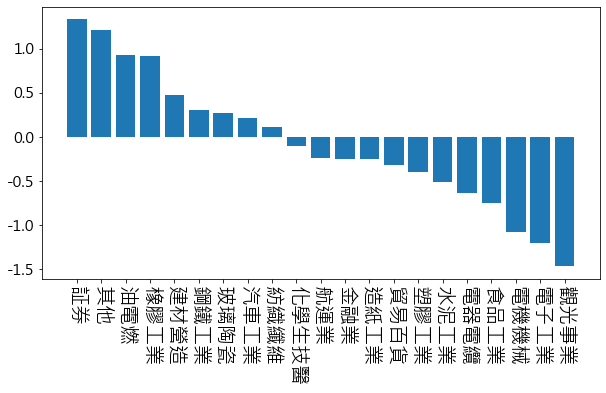

In [61]:
# 各產業走勢
plt.figure(figsize=(10,5)) # 調整圖片大小
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 將橫軸字體調成中文
plt.rcParams['axes.unicode_minus']=False
# 若遇到中文無法顯示的問題 ：
# https://medium.com/marketingdatascience/%E8%A7%A3%E6%B1%BApython-3-matplotlib%E8%88%87seaborn%E8%A6%96%E8%A6%BA%E5%8C%96%E5%A5%97%E4%BB%B6%E4%B8%AD%E6%96%87%E9%A1%AF%E7%A4%BA%E5%95%8F%E9%A1%8C-f7b3773a889b
plt.xticks(rotation = 270) # X軸的字體旋轉270度
plt.xticks(fontsize=20) # 調整 X軸字體大小
plt.yticks(fontsize=15) # 調整 Y軸字體大小
plt.bar(x=ind_sorted.index,height =ind_sorted['weight_avg_return'])